# Week 6 - Classification models  

## Part 4: Travel mode choice - Hierarchical models

In this part, is where we start to make things more interesting :-)

We will revisit the original real world problem of travel model choice (with 4 classes), but this time we shall consider an hierarchical model. 

More on that later, for now the same stuff from part 2: imports, loading data, preprocessing, train/test split, etc.

Import required libraries:

In [14]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import pystan
import pystan_utils

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

Load data:

In [2]:
# load csv
df = pd.read_csv("modechoice_data.csv")
df.head()

,Unnamed: 0,individual,hinc,psize,ttme_air,invc_air,invt_air,gc_air,ttme_train,invc_train,invt_train,gc_train,ttme_bus,invc_bus,invt_bus,gc_bus,invc_car,invt_car,gc_car,mode_chosen
0,0,70.0,30.0,4.0,10.0,61.0,80.0,73.0,44.0,24.0,350.0,77.0,53.0,19.0,395.0,79.0,4.0,314.0,52.0,1.0
1,1,8.0,15.0,4.0,64.0,48.0,154.0,71.0,55.0,25.0,360.0,80.0,53.0,14.0,462.0,84.0,4.0,351.0,57.0,2.0
2,2,62.0,35.0,2.0,64.0,58.0,74.0,69.0,30.0,21.0,295.0,66.0,53.0,24.0,389.0,83.0,7.0,315.0,55.0,2.0
3,3,61.0,40.0,3.0,45.0,75.0,75.0,96.0,44.0,33.0,418.0,96.0,53.0,28.0,463.0,98.0,5.0,291.0,49.0,1.0
4,4,27.0,70.0,1.0,20.0,106.0,190.0,127.0,34.0,72.0,659.0,143.0,35.0,33.0,653.0,104.0,44.0,592.0,108.0,1.0


Preprocess data:

In [6]:
# separate between features/inputs (X) and target/output variables (y)
mat = df.as_matrix()
X = mat[:,2:-1]
print(X.shape)
y = mat[:,-1].astype("int")
print(y.shape)
ind = mat[:,1].astype("int")
print(ind.shape)

(394, 17)
(394,)
(394,)


In [7]:
# standardize input features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

Train/test split:

In [8]:
train_perc = 0.66 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
ind_train = ind[ix_train]
ind_test = ind[ix_test]
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 260
num test: 134


Our baseline logistic regression model from sklearn:

In [9]:
# create and fit logistic regression model
logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(X_train, y_train)

# make predictions for test set
y_hat = logreg.predict(X_test)
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

predictions: [2 2 4 4 4 2 1 2 1 4 4 3 1 4 2 1 1 2 1 2 4 4 4 4 2 4 2 4 1 2 4 4 4 2 3 4 1
 3 2 1 4 4 2 2 2 4 1 3 2 3 1 4 4 1 1 4 2 4 1 1 3 2 4 2 4 4 4 3 2 1 2 4 2 4
 4 4 1 4 4 2 4 4 1 4 3 4 4 4 1 4 3 1 4 2 1 4 1 1 4 4 1 1 4 1 3 2 4 4 4 1 4
 4 1 1 3 1 1 4 3 2 4 1 4 2 1 1 2 2 2 1 4 4 4 2]
true values: [4 2 2 4 4 2 1 2 4 4 4 4 1 2 2 1 3 4 1 2 4 3 1 4 2 4 2 1 3 2 4 4 4 4 2 1 1
 3 2 1 4 2 2 2 4 1 1 3 2 3 1 2 4 4 1 4 2 4 4 3 3 4 4 4 4 1 1 3 2 1 2 4 2 4
 4 4 1 2 4 2 4 4 1 4 3 1 4 4 1 4 3 1 1 2 4 4 4 4 4 1 4 3 3 1 3 2 4 4 4 1 4
 4 4 1 4 1 1 4 3 2 1 1 4 2 4 1 2 4 2 1 1 1 4 4]
Accuracy: 0.679104477612


## Hierarchical logistic regression in STAN

We will now implement a hierarchical logistic regression. The motivation is actually quite simple. Our dataset consists of multiple observations from various individuals. However, when we build our logistic regression in STAN, our specification assumes that all individuals share a unique set of bias (alpha) coefficients (beta). In other words, this is equivalent to assuming, for example, that all individuals are equally biased towards a given mode (e.g. car). This is obviously a very strong assumption, right? We should allow different individuals to have different biases (alpha). (We could also consider different coefficients per individual, but for the sake of simplicy, we will just focus on the bias parameters)

This can be done by placing a hierarchical prior on the intercepts (alpha). The generative process then becomes:

1. For each class $c \in \{1,\dots,C\}$
    2. Draw global intercept mean $\mu_c \sim \mathcal{N}(0,10)$
    3. Draw global intercept variance $\sigma_c \sim \mbox{Cauchy}(0,10)$
    4. Draw prior on intercept $\boldsymbol\alpha_c \sim \mathcal{N}(\mu_c \textbf{1},\sigma_c \textbf{I})$
    5. Draw prior on coefficients $\boldsymbol\beta_c \sim \mathcal{N}(\textbf{0},10 \, \textbf{I})$ (this the same as before...)
6. For each data point $n=\{1,\dots,N\}$
    7. Draw target class $y_n \sim \mbox{Multinomial}(\mbox{Softmax}(\textbf{x}_n,\boldsymbol\alpha_1^{i_n},\dots,\boldsymbol\alpha_C^{i_n},\boldsymbol\beta_1,\dots,\boldsymbol\beta_C))$
    
where $i_n$ is used to denote the individual to which the $n^{th}$ observation corresponds to.

Notice that now, instead of a single intercept per class $\alpha_c$ for all individual, we now have a vector of intercepts $\boldsymbol\alpha_c$ for each class $c$: one intercept parameter per individual! However, all these intercept share a global (population-level) prior.

Lets try to implement this in STAN. Can you do it? :-) 

In [10]:
# define Stan model
model_definition = """

data {
    int<lower=0> N;             // number of data items
    int<lower=1> D;             // number of predictors
    int<lower=1> C;             // number of classes
    int<lower=1> I;             // number of individuals
    int<lower=1> ind[N];        // information about the individual
    matrix[N,D] X;              // predictor matrix
    int<lower=1,upper=C> y[N];  // classes vector
}
parameters {
    vector[C] mu_prior;
    vector<lower=0>[C] sigma_prior;
    matrix[C, I] alpha; // intercepts (biases) for each individual 
    matrix[C, D] beta;  // coefficients for predictors
} 
model {
    for (c in 1:C) {
        mu_prior[c] ~ normal(0,10);    // hyper-prior on the intercepts mean
        sigma_prior[c] ~ cauchy(0,10); // hyper-prior on the intercepts variance
        alpha[c] ~ normal(mu_prior[c], sigma_prior[c]);
        beta[c] ~ normal(0,10);        // prior on the coefficients
    }
    for (n in 1:N)
        y[n] ~ categorical(softmax(alpha[:,ind[n]] + beta * X[n]')); // likelihood
}
"""

Prepare input data for STAN, compile STAN program and run inference using ADVI (much faster in this case):

In [11]:
# prepare data for Stan model
N, D = X_train.shape
C = int(y_train.max())
I = ind.max()
print("N=%d, D=%d, C=%d, I=%d" % (N,D,C,I))
data = {'N': N, 'D': D, 'C': C, 'I':I, 'ind':ind_train, 'X': X_train, 'y': y_train}

N=260, D=17, C=4, I=80


In [12]:
%%time
# create Stan model object
sm = pystan.StanModel(model_code=model_definition)
fit = sm.vb(data=data, iter=10000, algorithm="meanfield", grad_samples=10, seed=42, verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_eb0cadbe23ce4254aecddddd9d6fde04 NOW.


CPU times: user 1min 4s, sys: 461 ms, total: 1min 4s
Wall time: 1min 35s


Lets plot the posterior distributions of some of the parameters of our model (you may have called these variables something else...):

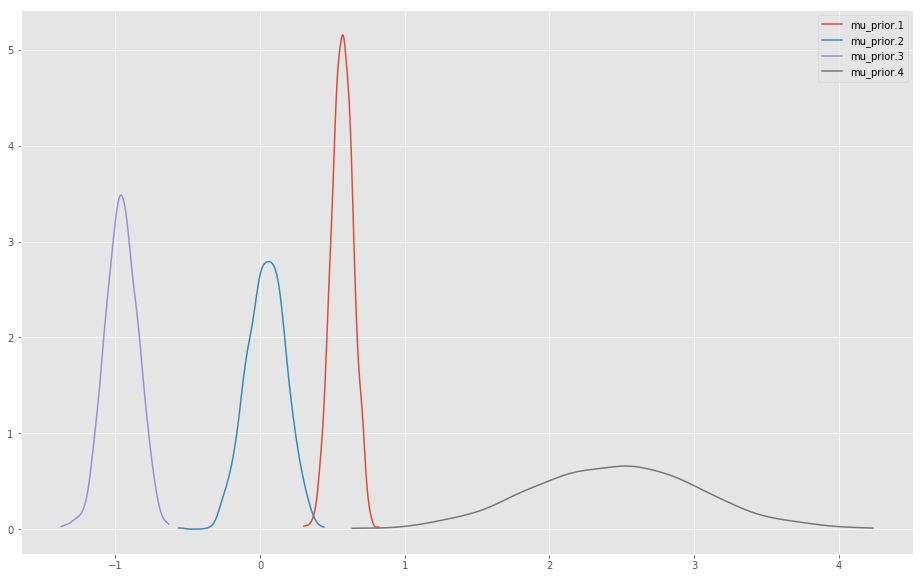

In [26]:
pystan_utils.vb_plot_variables(fit, "mu_prior")

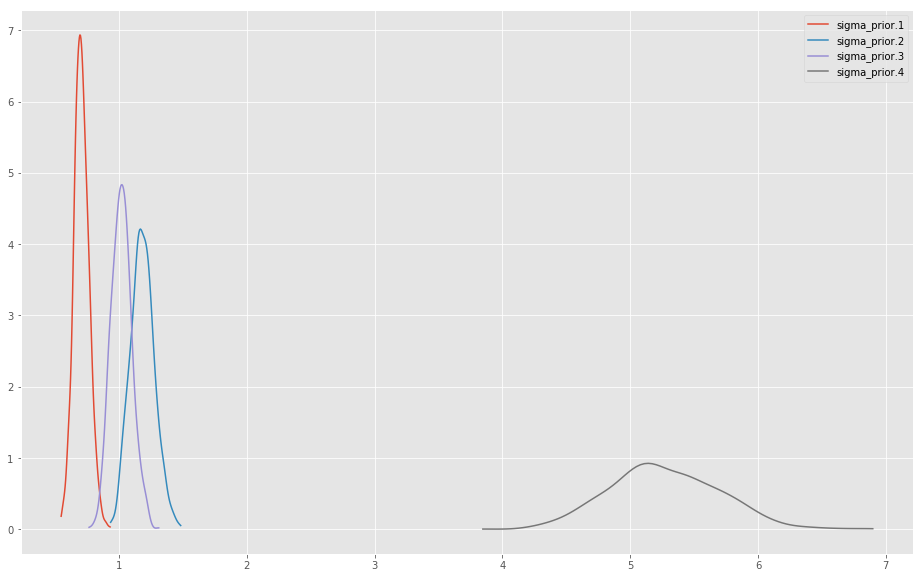

In [27]:
pystan_utils.vb_plot_variables(fit, "sigma_prior")

We can now use the inferred posteriors to make predictions. Lets first use the "pystan_utils" package to extract the expected values of the posterior distribution of the model parameters:

In [ ]:
# get fitted parameters
mu_prior = pystan_utils.vb_extract_variable(fit, "mu_prior", var_type="vector")
sigma_prior = pystan_utils.vb_extract_variable(fit, "sigma_prior", var_type="vector")
alpha = pystan_utils.vb_extract_variable(fit, "alpha", var_type="matrix", dims=(C,I))
beta = pystan_utils.vb_extract_variable(fit, "beta", var_type="matrix", dims=(C,D))

Using expected values of the parameters, we can make predictions for the testset. However, we need to account for the fact that we now have different bias parameters per-individual, and adapt the code for making predictions accordingly. Make sure that you understand the code below. As always, if something is not 100% clear, ask! :-)

In [21]:
# make predictions for test set
y_hat = alpha[:,ind_test-1] + np.dot(beta, X_test.T)
y_hat = np.argmax(y_hat, axis=0) + 1
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

predictions: [2 2 4 4 4 2 1 4 4 4 4 4 1 2 2 1 4 4 1 2 1 3 4 4 2 4 2 1 1 2 4 4 4 2 3 1 1
 3 2 4 4 2 2 2 4 1 1 3 2 3 1 2 4 4 1 4 2 4 4 1 3 4 4 2 4 1 4 3 2 1 2 4 2 4
 4 4 1 4 4 2 4 4 1 4 3 2 4 4 1 4 3 1 1 2 1 4 4 1 4 1 1 4 2 4 3 2 4 4 2 1 4
 2 3 1 3 1 1 4 3 2 3 1 4 2 1 1 2 2 2 1 1 4 4 4]
true values: [4 2 2 4 4 2 1 2 4 4 4 4 1 2 2 1 3 4 1 2 4 3 1 4 2 4 2 1 3 2 4 4 4 4 2 1 1
 3 2 1 4 2 2 2 4 1 1 3 2 3 1 2 4 4 1 4 2 4 4 3 3 4 4 4 4 1 1 3 2 1 2 4 2 4
 4 4 1 2 4 2 4 4 1 4 3 1 4 4 1 4 3 1 1 2 4 4 4 4 4 1 4 3 3 1 3 2 4 4 4 1 4
 4 4 1 4 1 1 4 3 2 1 1 4 2 4 1 2 4 2 1 1 1 4 4]
Accuracy: 0.783582089552


Now, that is a signficant improvement, right? We improved the accuracy of our model from 67.9% to about 78.4%! (Hopefully you were able to obtain a similar or even better result :-)

Did you see how your prior knowledge about the problem can make a substantial difference when building a model for it? This is how things are done in the model-based machine learning approach!

Given the posterior distributions inferred by STAN, we can even analyse the biases of different individuals identified by out model:

In [22]:
for i in range(I):
    print(i, alpha[:,i])

0 [ 0.58266789 -0.2529364  -0.9521211   6.74234459]
1 [ 0.64295738  0.0303586  -1.19126283  1.82653738]
2 [ 0.77400521 -0.0806438  -1.1049635  -0.19998082]
3 [ 0.72243269  0.12530821 -1.17085762 -1.33063487]
4 [ 0.59452469 -0.64780872 -0.33900543  0.04751799]
5 [ 0.5086094  -0.21101319 -0.60118615  0.52498454]
6 [ 0.2574214  -0.14532791 -0.27664969  2.70988024]
7 [ 0.41722873  0.00678475 -0.58828696 -0.09316847]
8 [ 0.60819952  0.06058608 -0.97465653  0.12356268]
9 [ 0.58368515 -0.23883909 -0.89581743  7.45367308]
10 [ 0.85222975  0.10819118 -1.22064754 -2.36556174]
11 [ 0.53863888  0.26571844 -0.90238662  1.18977566]
12 [ 0.41523024  0.69259391 -1.12706253  4.38428554]
13 [ 0.51707518  0.18833694 -0.96575966 -0.31913113]
14 [ 0.56715655  0.1646114  -1.12921667  1.76262578]
15 [  5.29307970e-01  -2.05725196e-03  -9.53720912e-01   4.75826938e+00]
16 [ 0.6535061   0.18451442 -1.00008792 -0.43169122]
17 [ 0.54181428  0.00969389 -0.91395555  3.66861345]
18 [ 0.50785732  0.47825943 -1.07929

Perhaps a histogram allows for a better global analysis:

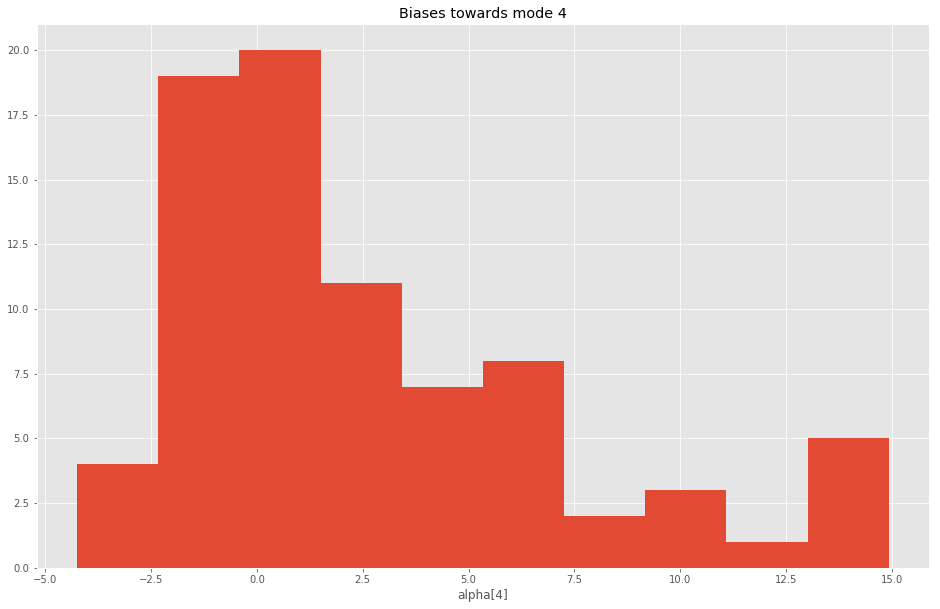

In [23]:
# histogram of biases towards mode 4 (car)
plt.hist(alpha[3,:])
plt.title("Biases towards mode 4")
plt.xlabel("alpha[4]")
plt.show()

We can observed that, for most individuals the biases is around 0. However, we can also see that a few individuals really love their cars!

Reflection exercise: can you think of ways in which you could use this model to try to identify policies (e.g. price changes or making terminals more efficient) that would allow to shift people's travel mode choices away from the car (e.g. towards public transport)?